In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Network_data.csv")


# the head rows of the dataframe.

In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

FLOW_ID PROTOCOL_MAP  L4_SRC_PORT   IPV4_SRC_ADDR  L4_DST_PORT  \
0  372018590          udp        53950   10.114.232.40           53   
1  368604472          tcp        37914  10.114.241.166        38303   
2  367513992          tcp        33216  10.114.241.166        18757   
3  371997670          udp        48627  10.114.225.205           53   
4  374311119          udp        35939  10.114.225.205           53   

    IPV4_DST_ADDR  FIRST_SWITCHED  FLOW_DURATION_MILLISECONDS  LAST_SWITCHED  \
0    10.114.226.5      1647760833                           1     1647760833   
1  10.114.224.218      1647686725                           1     1647686725   
2  10.114.224.116      1647680044                           0     1647680044   
3    10.114.226.5      1647760172                           0     1647760172   
4    10.114.226.5      1647780916                           0     1647780916   

   PROTOCOL  ...  TOTAL_PKTS_EXP  TOTAL_BYTES_EXP  IN_BYTES  IN_PKTS  \
0        17  ...               0                0       165        2   
1         6  ...               0                0        44        1   
2         6  ...               0                0        44        1   
3        17  ...               0                0       128        2   
4        17  ...               0                0       172        2   

   OUT_BYTES  OUT_PKTS  ANALYSIS_TIMESTAMP  ANOMALY          ALERT  ID  
0        275         2          1647760873      0.0           None   0  
1         40         1          1647687338      0.0  Port Scanning   1  
2         40         1          1647680115      1.0  Port Scanning   2  
3        160         2          1647760207      0.0           None   3  
4        300         2          1647780984      0.0           None   4  

[5 rows x 33 columns]

# Encoder : 

In [4]:
from sklearn import preprocessing

# Apply label encoding
le = preprocessing.LabelEncoder()
le.fit(df['IPV4_SRC_ADDR'])
df['IPV4_SRC_ADDR']=le.transform(df['IPV4_SRC_ADDR'])

le.fit(df['IPV4_DST_ADDR'])
df['IPV4_DST_ADDR']=le.transform(df['IPV4_DST_ADDR'])

from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoding
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['PROTOCOL_MAP']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['PROTOCOL_MAP']))
final_df = df.join(encoded_df)
final_df.drop('PROTOCOL_MAP', axis=1, inplace=True)

# fill 0 in one-hot encoding
final_df['PROTOCOL_MAP_udp'] = final_df['PROTOCOL_MAP_udp'].fillna(0)
final_df['PROTOCOL_MAP_tcp'] = final_df['PROTOCOL_MAP_tcp'].fillna(0)
final_df['PROTOCOL_MAP_gre'] = final_df['PROTOCOL_MAP_gre'].fillna(0)
final_df['PROTOCOL_MAP_icmp'] = final_df['PROTOCOL_MAP_icmp'].fillna(0)
final_df['PROTOCOL_MAP_ipv6-icmp'] = final_df['PROTOCOL_MAP_ipv6-icmp'].fillna(0)


# Split the dataset into Train and Test sets with test_size=30% and random_state=23

In [5]:
from sklearn.model_selection import train_test_split
X = final_df.drop('ALERT',axis=1)
y = final_df['ALERT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=11)

# DecisionTree

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score , ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

print("--Decision Tree--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,predictions) , "\n")
accuracyTD= accuracy_score(y_test,predictions)*100
print("accuracy : ",accuracyTD)

--Decision Tree--

 confusion matrix : 
 [[    2     0     0]
 [    0 27596     0]
 [    0     1  7553]] 

accuracy :  99.99715521165226


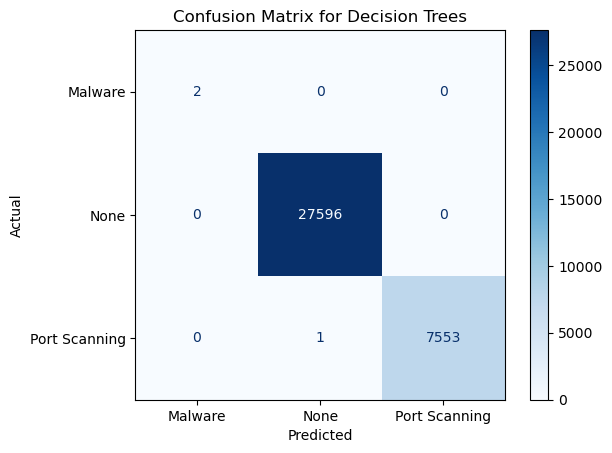

In [7]:
display_dtree=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions),display_labels=dtree.classes_)
display_dtree.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Trees')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# GaussianNB

In [8]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
 
y_pred = gnb.predict(X_test)
print("--Naive Bayes Classifiers--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,y_pred), "\n")
accuracyNB = accuracy_score(y_test,y_pred)*100
print("accuracy : ",accuracyNB)

--Naive Bayes Classifiers--

 confusion matrix : 
 [[    2     0     0]
 [    0 27411   185]
 [    0     3  7551]] 

accuracy :  99.46517979062358


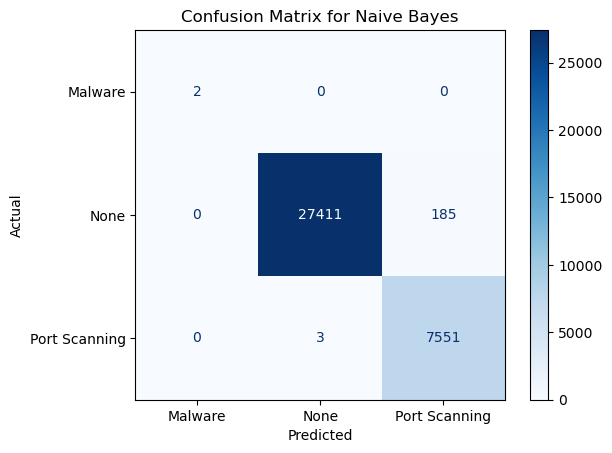

In [9]:
display_gnb=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=gnb.classes_ )
display_gnb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 20, criterion = 'gini', max_depth = 4) 
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print("--Random Forest--\n")
print(" confusion matrix : \n",confusion_matrix(y_test,rfc_pred) , "\n")
accuracy_RF= accuracy_score(y_test,rfc_pred)*100
print("accuracy : ",accuracy_RF)

--Random Forest--

 confusion matrix : 
 [[    2     0     0]
 [    0 27444   152]
 [    0     4  7550]] 

accuracy :  99.55621301775149


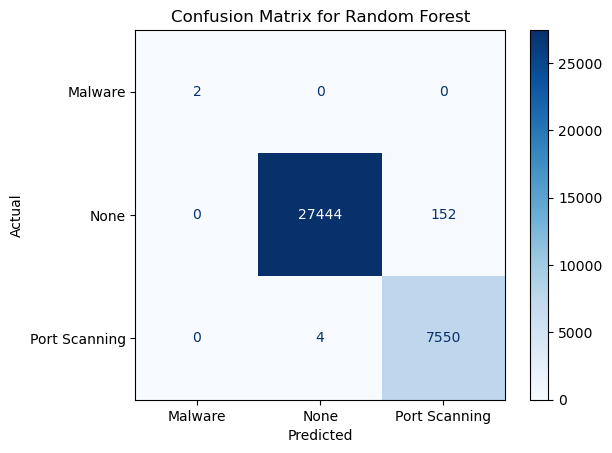

In [11]:
display_rfc=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,rfc_pred),display_labels=rfc.classes_)
display_rfc.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Comparison of accuracy percentage

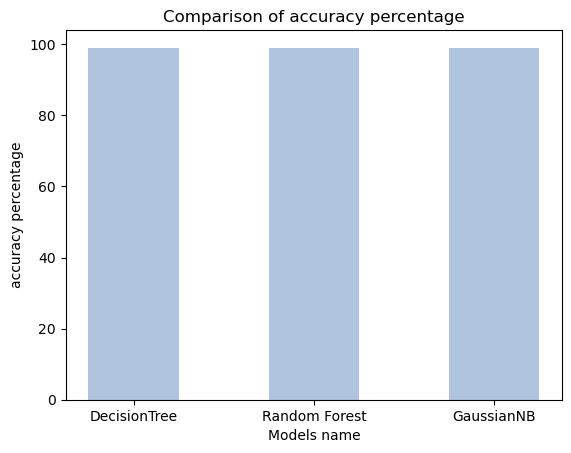

In [12]:
nameOfModel=np.array(["DecisionTree","Random Forest", "GaussianNB" ])
acc=np.array([int(accuracyTD),int(accuracy_RF),int(accuracyNB)])

plt.bar(nameOfModel, acc, color= "lightsteelblue",width=0.5);
plt.xlabel("Models name")
plt.ylabel("accuracy percentage")
plt.title("Comparison of accuracy percentage")
plt.show()

# Conclusion

### Because we need classify network conncetions, we used classification algorithms and tried KNeighbour, GaussianNB, RandomForest, Support Vector Machine, and Decision Tree. We found the highest accuracy in these three algorithms in order: Decision Tree, GaussianNB, RandomForet.